# I. Install and load library

In [16]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, PolynomialFeatures
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.metrics import confusion_matrix
from xgboost import XGBClassifier
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.under_sampling import RandomUnderSampler
import optuna
import wandb
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import warnings
warnings.filterwarnings("ignore")
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score
import logging
import joblib
from dotenv import load_dotenv
load_dotenv()

True

In [17]:
logging.basicConfig(level=logging.INFO,
                    format="%(asctime)s %(message)s",
                    datefmt='%d-%m-%Y %H:%M:%S')

logger = logging.getLogger()

# II. Downloading file from Wandb 

In [18]:
run = wandb.init(project="diabetes", job_type="train")

In [19]:
WANDB_API_KEY=os.environ.get('WANDB_API_KEY')
!wandb login --relogin $WANDB_API_KEY

wandb: Appending key for api.wandb.ai to your netrc file: C:\Users\PC\_netrc
wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin


In [20]:
logger.info("Downloading and reading train artifact")
artifact_X_train = wandb.use_artifact('diabetes/X_train.csv:latest', type='preprocessing')
artifact_X_val = wandb.use_artifact('diabetes/X_val.csv:latest', type='preprocessing')
artifact_y_train = wandb.use_artifact('diabetes/y_train.csv:latest', type='preprocessing')
artifact_y_val = wandb.use_artifact('diabetes/y_val.csv:latest', type='preprocessing')

X_train_dir = artifact_X_train.download()
X_val_dir = artifact_X_val.download()
y_train_dir = artifact_y_train.download()
y_val_dir = artifact_y_val.download()

X_train_path = os.path.join(X_train_dir, "X_train.csv")
X_val_path = os.path.join(X_val_dir, "X_val.csv")
y_train_path = os.path.join(y_train_dir, "y_train.csv")
y_val_path = os.path.join(y_val_dir, "y_val.csv")

X_train = pd.read_csv(X_train_path)
X_val = pd.read_csv(X_val_path)
y_train = pd.read_csv(y_train_path)
y_val = pd.read_csv(y_val_path)

06-05-2025 11:33:34 Downloading and reading train artifact
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  


# III. Training

06-05-2025 11:33:46 Training
06-05-2025 11:33:50 Infering
06-05-2025 11:33:50 Evaluation metrics
06-05-2025 11:33:50 Accuracy: 0.7153169577964473
06-05-2025 11:33:50 Precision: 0.29851664502016545
06-05-2025 11:33:50 Recall: 0.7715547703180212
06-05-2025 11:33:50 F1: 0.7572737402901446
06-05-2025 11:33:50 Infering Bias
06-05-2025 11:33:50 Bias Evaluation metrics
06-05-2025 11:33:51 Bias Accuracy: 0.737205506451911
06-05-2025 11:33:51 Bias Precision: 0.8755518432729459
06-05-2025 11:33:51 Bias Recall: 0.836925382343867
06-05-2025 11:33:51 Bias F1: 0.7756800649760024
06-05-2025 11:33:51 Uploading figures


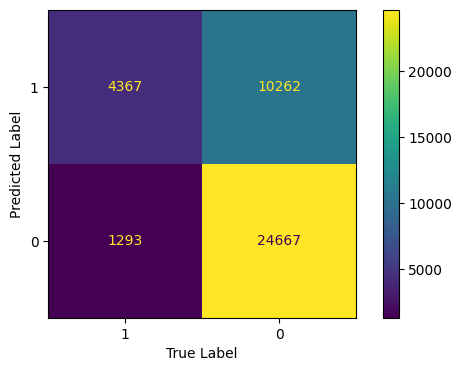

06-05-2025 11:33:51 Uploading figures


In [ ]:
rus = RandomUnderSampler(random_state=42)
X_train, y_train = rus.fit_resample(X_train, y_train)

default_pipe = ImbPipeline(steps=[
    ("scaler", MinMaxScaler()),
    ("selectkbest", SelectKBest(score_func=chi2, k=15)),
    ("poly", PolynomialFeatures(degree=2, include_bias=False)),
    ("xgb", XGBClassifier(use_label_encoder=False, eval_metric="logloss", random_state=42))
])

logger.info("Training")
default_pipe.fit(X_train, y_train)

logger.info("Infering")
y_pred = default_pipe.predict(X_val)

logger.info("Evaluation metrics")
precision = precision_score(y_val, y_pred, zero_division=1)
recall = recall_score(y_val, y_pred, zero_division=1)
acc = accuracy_score(y_val, y_pred)
f1 = f1_score(y_val,y_pred, average='weighted', zero_division=1)

logger.info("Accuracy: {}".format(acc))
logger.info("Precision: {}".format(precision))
logger.info("Recall: {}".format(recall))
logger.info("F1: {}".format(f1))

run.summary["Accuracy"] = acc
run.summary["Precision"] = precision
run.summary["Recall"] = recall
run.summary["F1"] = f1

logger.info("Infering Bias")
predict_bias = default_pipe.predict(X_train)

logger.info("Bias Evaluation metrics")
f1 = f1_score(y_train, predict_bias,average='weighted', zero_division=1)
precision = precision_score(y_train, predict_bias, zero_division=1, average='weighted')
recall = recall_score(y_train, predict_bias, zero_division=1)
acc = accuracy_score(y_train, predict_bias)

logger.info("Bias Accuracy: {}".format(acc))
logger.info("Bias Precision: {}".format(precision))
logger.info("Bias Recall: {}".format(recall))
logger.info("Bias F1: {}".format(f1))


logger.info("Uploading figures")

fig_confusion_matrix, ax = plt.subplots(1,1,figsize=(7,4))
ConfusionMatrixDisplay(confusion_matrix(y_pred,y_val,labels=[1,0]),
                       display_labels=["1","0"]).plot(values_format=".0f",ax=ax)

ax.set_xlabel("True Label")
ax.set_ylabel("Predicted Label")
plt.show()

logger.info("Uploading figures")
run.log(
    {
        "confusion_matrix": wandb.Image(fig_confusion_matrix),
    }
)

In [22]:
wandb.sklearn.plot_confusion_matrix(y_val, y_pred, [0,1])

In [23]:
wandb.sklearn.plot_class_proportions(y_train, y_val, [0,1])

# IV. Optimizing

In [ ]:
def objective(trial):
    params = {
        "max_depth": trial.suggest_int("max_depth", 3, 10),
        "n_estimators": trial.suggest_int("n_estimators", 50, 300), 
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3, log=True),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0)
    }

    pipe = ImbPipeline(steps=[
        ("scaler", MinMaxScaler()),
        ("selectkbest", SelectKBest(score_func=chi2, k=15)),
        ("poly", PolynomialFeatures(degree=2, include_bias=False)),
        ("xgb", XGBClassifier(
            use_label_encoder=False,
            eval_metric="logloss",
            random_state=42,
            **params
        ))
    ])

    pipe.fit(X_train, y_train)

    y_pred = pipe.predict(X_val)
    
    f1 = f1_score(y_val, y_pred,average='weighted', zero_division=1)
    precision = precision_score(y_val, y_pred, zero_division=1, average='weighted')
    recall = recall_score(y_val, y_pred, zero_division=1)
    acc = accuracy_score(y_val, y_pred)

    logger.info("Accuracy: {}".format(acc))
    logger.info("Precision: {}".format(precision))
    logger.info("Recall: {}".format(recall))
    logger.info("F1: {}".format(f1))

    run.summary["Accuracy"] = acc
    run.summary["Precision"] = precision
    run.summary["Recall"] = recall
    run.summary["F1"] = f1

    return f1  

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50)

print("Best hyperparameters:", study.best_params)

[I 2025-05-06 11:33:52,259] A new study created in memory with name: no-name-830d175f-9019-466a-bab3-a0edea213a67


06-05-2025 11:34:05 Accuracy: 0.7146517529379881
06-05-2025 11:34:05 Precision: 0.8592309838741623
06-05-2025 11:34:05 Recall: 0.7717314487632508
06-05-2025 11:34:05 F1: 0.7567421931000377
[I 2025-05-06 11:34:05,066] Trial 0 finished with value: 0.7567421931000377 and parameters: {'max_depth': 8, 'n_estimators': 246, 'learning_rate': 0.06926507282888843, 'subsample': 0.5426203499177907, 'colsample_bytree': 0.7422272538699461}. Best is trial 0 with value: 0.7567421931000377.
06-05-2025 11:34:10 Accuracy: 0.7150952228436276
06-05-2025 11:34:10 Precision: 0.8618835496374639
06-05-2025 11:34:10 Recall: 0.7851590106007067
06-05-2025 11:34:10 F1: 0.7572794352356244
[I 2025-05-06 11:34:10,590] Trial 1 finished with value: 0.7572794352356244 and parameters: {'max_depth': 7, 'n_estimators': 140, 'learning_rate': 0.10026168818165165, 'subsample': 0.6383812873272978, 'colsample_bytree': 0.6325200921063794}. Best is trial 1 with value: 0.7572794352356244.
06-05-2025 11:34:28 Accuracy: 0.7156865160

Best hyperparameters: {'max_depth': 4, 'n_estimators': 285, 'learning_rate': 0.02505940719962478, 'subsample': 0.99932686899572, 'colsample_bytree': 0.9104180416301417}


In [ ]:
final_pipe = ImbPipeline(steps=[
    ("selectkbest", SelectKBest(score_func=chi2, k=15)),
    ("scaler", MinMaxScaler()),
    ("poly", PolynomialFeatures(degree=2, include_bias=False)),
    ("xgb", XGBClassifier(
        use_label_encoder=False,
        eval_metric="logloss",
        random_state=42,
        **study.best_params
    ))
])

final_pipe.fit(X_train, y_train)

y_pred = final_pipe.predict(X_val)
f1 = f1_score(y_val, y_pred,average='weighted', zero_division=1)
precision = precision_score(y_val, y_pred, zero_division=1, average='weighted')
recall = recall_score(y_val, y_pred, zero_division=1)
acc = accuracy_score(y_val, y_pred)

logger.info("Accuracy: {}".format(acc))
logger.info("Precision: {}".format(precision))
logger.info("Recall: {}".format(recall))
logger.info("F1: {}".format(f1))

run.summary["Accuracy"] = acc
run.summary["Precision"] = precision
run.summary["Recall"] = recall
run.summary["F1"] = f1

06-05-2025 11:39:21 Accuracy: 0.7209096060509005
06-05-2025 11:39:22 Precision: 0.8634701590141027
06-05-2025 11:39:22 Recall: 0.7879858657243817
06-05-2025 11:39:22 F1: 0.7619922191790719


# VI. Export model

In [26]:
artifact_type = "inference_artifact"
artifact_model = "model_export"

In [27]:
logger.info("Dumping the artifacts to disk")
joblib.dump(final_pipe, artifact_model)

06-05-2025 11:39:22 Dumping the artifacts to disk


['model_export']

In [28]:
artifact = wandb.Artifact(artifact_model,
                          type=artifact_type,
                          description="A full pipeline composed of a Preprocessing Stage and a Decision Tree model"
                          )

logger.info("Logging model artifact")
artifact.add_file(artifact_model)
run.log_artifact(artifact)

06-05-2025 11:39:22 Logging model artifact


<Artifact model_export>

In [29]:
run.finish()

Accuracy,0.72091
F1,0.76199
Precision,0.86347
Recall,0.78799
